# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

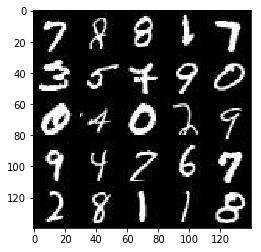

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

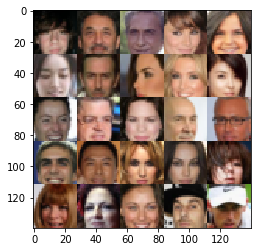

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32,(None,z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #28x28x1
        
        conv1 = tf.layers.conv2d(images,64,5,strides=2, padding='same')
        relu1 = tf.maximum(alpha*conv1,conv1)
        #14x14x64
        #print(relu1.shape)
        
        conv2 = tf.layers.conv2d(relu1,128,5,strides=2, padding='same')
        bn2 =tf.layers.batch_normalization(conv2,training =True)
        relu2 = tf.maximum(alpha*bn2,bn2)
        #7x7x128
        #print(relu2.shape)
        
        conv3 = tf.layers.conv2d(relu2,256,5,strides=2, padding='same')
        bn3 =tf.layers.batch_normalization(conv3,training =True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        #4x4x256
        #print(relu3.shape)
        
        flat = tf.reshape(relu3,(-1, 4*4*256))
        
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse = reuse):
        
        #scope.reuse_variables()
        
        d1 = tf.layers.dense(z,7*7*256)
        
        d1 = tf.reshape(d1,(-1,7,7,256))
        d1 = tf.layers.batch_normalization(d1,training = is_train)
        d1 = tf.maximum(alpha*d1,d1)
        #7x7x256
        #print(d1.shape)
        
        conv1 = tf.layers.conv2d_transpose(d1,128,5,strides = 2, padding = 'same')
        conv1 = tf.layers.batch_normalization(conv1,training=is_train)
        conv1 = tf.maximum(alpha*conv1,conv1)
        #14x14x128
        #print(conv1.shape)
        
        conv2 = tf.layers.conv2d_transpose(conv1,64,5,strides = 2, padding = 'same')
        conv2 = tf.layers.batch_normalization(conv2,training=is_train)
        conv2 = tf.maximum(alpha*conv2,conv2)
        #28x28x64
        
        logits = tf.layers.conv2d_transpose(conv2,out_channel_dim,5,strides = 1, padding = 'same')
        
        #print(logits.shape)
        
        out = tf.tanh(logits)
        
        
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #data_shape = np.array(data_shape)
    #print(data_shape)
    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    
    d_loss, g_loss = model_loss( input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate,beta1)
    
    tot_steps = epoch_count * (int)(data_shape[0]/batch_size)
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps+=1
                #rescaling from -0.5 to 0.5 to -1 to 1
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if (steps % 20 == 0) or (steps == tot_steps):
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epochs: {}/{} step: {}/{} ".format(epoch_i+1,epoch_count, steps, tot_steps), 
                            "Discriminator loss: {:.4f}".format(train_loss_d),
                            "Generator loss: {:.4f}".format(train_loss_g))
                    
                
                if (steps % 200 == 0) or (steps == tot_steps):
                    show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epochs: 1/2 step: 20/1874  Discriminator loss: 0.6961 Generator loss: 7.6879
Epochs: 1/2 step: 40/1874  Discriminator loss: 0.7784 Generator loss: 3.4863
Epochs: 1/2 step: 60/1874  Discriminator loss: 1.8258 Generator loss: 0.3786
Epochs: 1/2 step: 80/1874  Discriminator loss: 1.1976 Generator loss: 1.3277
Epochs: 1/2 step: 100/1874  Discriminator loss: 1.0961 Generator loss: 1.0485
Epochs: 1/2 step: 120/1874  Discriminator loss: 1.1891 Generator loss: 1.5606
Epochs: 1/2 step: 140/1874  Discriminator loss: 1.1067 Generator loss: 0.9158
Epochs: 1/2 step: 160/1874  Discriminator loss: 1.0553 Generator loss: 1.3271
Epochs: 1/2 step: 180/1874  Discriminator loss: 1.4020 Generator loss: 0.5730
Epochs: 1/2 step: 200/1874  Discriminator loss: 0.9248 Generator loss: 1.3136


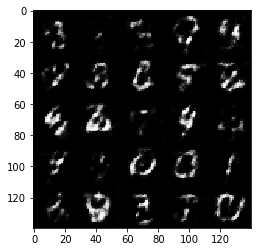

Epochs: 1/2 step: 220/1874  Discriminator loss: 1.0410 Generator loss: 1.3371
Epochs: 1/2 step: 240/1874  Discriminator loss: 1.0679 Generator loss: 1.6699
Epochs: 1/2 step: 260/1874  Discriminator loss: 1.2038 Generator loss: 2.2055
Epochs: 1/2 step: 280/1874  Discriminator loss: 1.0646 Generator loss: 1.7483
Epochs: 1/2 step: 300/1874  Discriminator loss: 1.1313 Generator loss: 1.5087
Epochs: 1/2 step: 320/1874  Discriminator loss: 1.1806 Generator loss: 1.5144
Epochs: 1/2 step: 340/1874  Discriminator loss: 1.5807 Generator loss: 0.4280
Epochs: 1/2 step: 360/1874  Discriminator loss: 1.1141 Generator loss: 1.3071
Epochs: 1/2 step: 380/1874  Discriminator loss: 1.0109 Generator loss: 1.4746
Epochs: 1/2 step: 400/1874  Discriminator loss: 0.9887 Generator loss: 1.3148


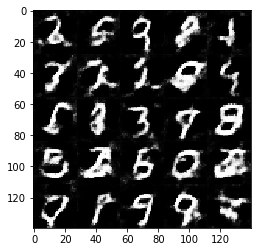

Epochs: 1/2 step: 420/1874  Discriminator loss: 1.5014 Generator loss: 0.4540
Epochs: 1/2 step: 440/1874  Discriminator loss: 1.0378 Generator loss: 1.6158
Epochs: 1/2 step: 460/1874  Discriminator loss: 1.0034 Generator loss: 1.1631
Epochs: 1/2 step: 480/1874  Discriminator loss: 1.0024 Generator loss: 0.9192
Epochs: 1/2 step: 500/1874  Discriminator loss: 1.1828 Generator loss: 1.3888
Epochs: 1/2 step: 520/1874  Discriminator loss: 1.6112 Generator loss: 0.4097
Epochs: 1/2 step: 540/1874  Discriminator loss: 1.1262 Generator loss: 0.8111
Epochs: 1/2 step: 560/1874  Discriminator loss: 1.1585 Generator loss: 1.2282
Epochs: 1/2 step: 580/1874  Discriminator loss: 1.0756 Generator loss: 1.0036
Epochs: 1/2 step: 600/1874  Discriminator loss: 1.3935 Generator loss: 0.5943


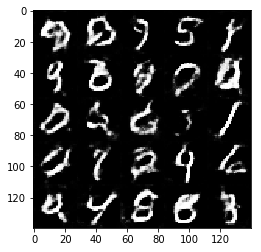

Epochs: 1/2 step: 620/1874  Discriminator loss: 1.0000 Generator loss: 1.3969
Epochs: 1/2 step: 640/1874  Discriminator loss: 1.1079 Generator loss: 0.7623
Epochs: 1/2 step: 660/1874  Discriminator loss: 0.9774 Generator loss: 0.9864
Epochs: 1/2 step: 680/1874  Discriminator loss: 1.4271 Generator loss: 0.5692
Epochs: 1/2 step: 700/1874  Discriminator loss: 0.9896 Generator loss: 1.2736
Epochs: 1/2 step: 720/1874  Discriminator loss: 1.0883 Generator loss: 0.7716
Epochs: 1/2 step: 740/1874  Discriminator loss: 1.0329 Generator loss: 0.8907
Epochs: 1/2 step: 760/1874  Discriminator loss: 0.9947 Generator loss: 0.9640
Epochs: 1/2 step: 780/1874  Discriminator loss: 1.0851 Generator loss: 0.9162
Epochs: 1/2 step: 800/1874  Discriminator loss: 1.2859 Generator loss: 0.6384


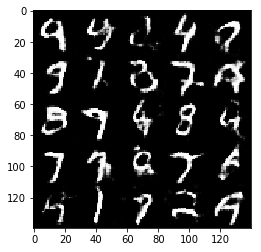

Epochs: 1/2 step: 820/1874  Discriminator loss: 1.0551 Generator loss: 0.9062
Epochs: 1/2 step: 840/1874  Discriminator loss: 1.0887 Generator loss: 0.8090
Epochs: 1/2 step: 860/1874  Discriminator loss: 1.1698 Generator loss: 0.7864
Epochs: 1/2 step: 880/1874  Discriminator loss: 1.0568 Generator loss: 0.8156
Epochs: 1/2 step: 900/1874  Discriminator loss: 1.5122 Generator loss: 0.4167
Epochs: 1/2 step: 920/1874  Discriminator loss: 1.1015 Generator loss: 0.8344
Epochs: 2/2 step: 940/1874  Discriminator loss: 0.9638 Generator loss: 1.0103
Epochs: 2/2 step: 960/1874  Discriminator loss: 0.9822 Generator loss: 0.8974
Epochs: 2/2 step: 980/1874  Discriminator loss: 0.9624 Generator loss: 1.1344
Epochs: 2/2 step: 1000/1874  Discriminator loss: 0.8810 Generator loss: 1.2063


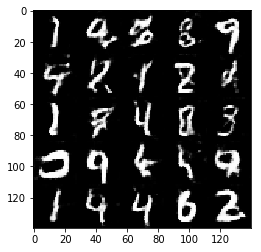

Epochs: 2/2 step: 1020/1874  Discriminator loss: 1.1475 Generator loss: 0.6882
Epochs: 2/2 step: 1040/1874  Discriminator loss: 1.0289 Generator loss: 0.8677
Epochs: 2/2 step: 1060/1874  Discriminator loss: 1.4403 Generator loss: 2.2947
Epochs: 2/2 step: 1080/1874  Discriminator loss: 1.3161 Generator loss: 0.6110
Epochs: 2/2 step: 1100/1874  Discriminator loss: 1.0043 Generator loss: 0.9142
Epochs: 2/2 step: 1120/1874  Discriminator loss: 0.9732 Generator loss: 1.5142
Epochs: 2/2 step: 1140/1874  Discriminator loss: 1.0240 Generator loss: 0.8343
Epochs: 2/2 step: 1160/1874  Discriminator loss: 1.5246 Generator loss: 0.5240
Epochs: 2/2 step: 1180/1874  Discriminator loss: 0.8923 Generator loss: 1.2569
Epochs: 2/2 step: 1200/1874  Discriminator loss: 0.9769 Generator loss: 1.0370


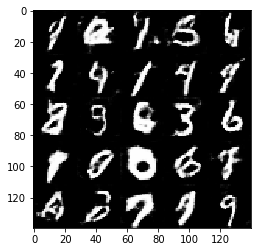

Epochs: 2/2 step: 1220/1874  Discriminator loss: 0.9362 Generator loss: 1.0247
Epochs: 2/2 step: 1240/1874  Discriminator loss: 1.0560 Generator loss: 1.0779
Epochs: 2/2 step: 1260/1874  Discriminator loss: 0.9589 Generator loss: 1.0114
Epochs: 2/2 step: 1280/1874  Discriminator loss: 1.0182 Generator loss: 1.0393
Epochs: 2/2 step: 1300/1874  Discriminator loss: 1.0098 Generator loss: 1.9525
Epochs: 2/2 step: 1320/1874  Discriminator loss: 1.1085 Generator loss: 0.8870
Epochs: 2/2 step: 1340/1874  Discriminator loss: 0.9222 Generator loss: 1.5488
Epochs: 2/2 step: 1360/1874  Discriminator loss: 1.1823 Generator loss: 0.7955
Epochs: 2/2 step: 1380/1874  Discriminator loss: 1.0609 Generator loss: 0.9401
Epochs: 2/2 step: 1400/1874  Discriminator loss: 0.9346 Generator loss: 1.0943


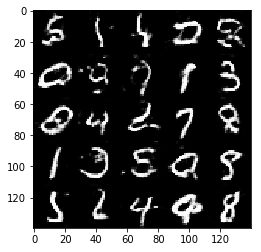

Epochs: 2/2 step: 1420/1874  Discriminator loss: 0.7235 Generator loss: 1.9035
Epochs: 2/2 step: 1440/1874  Discriminator loss: 1.0516 Generator loss: 0.8874
Epochs: 2/2 step: 1460/1874  Discriminator loss: 1.4617 Generator loss: 0.5152
Epochs: 2/2 step: 1480/1874  Discriminator loss: 1.0660 Generator loss: 0.8736
Epochs: 2/2 step: 1500/1874  Discriminator loss: 1.4669 Generator loss: 0.5875
Epochs: 2/2 step: 1520/1874  Discriminator loss: 0.8575 Generator loss: 1.5729
Epochs: 2/2 step: 1540/1874  Discriminator loss: 1.2727 Generator loss: 2.2056
Epochs: 2/2 step: 1560/1874  Discriminator loss: 0.9271 Generator loss: 1.6892
Epochs: 2/2 step: 1580/1874  Discriminator loss: 1.0079 Generator loss: 0.9360
Epochs: 2/2 step: 1600/1874  Discriminator loss: 1.2348 Generator loss: 0.7071


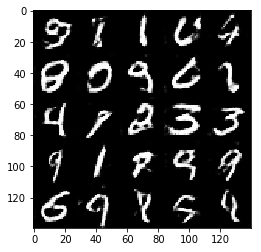

Epochs: 2/2 step: 1620/1874  Discriminator loss: 1.6986 Generator loss: 0.3968
Epochs: 2/2 step: 1640/1874  Discriminator loss: 0.8748 Generator loss: 1.7647
Epochs: 2/2 step: 1660/1874  Discriminator loss: 1.1797 Generator loss: 0.7213
Epochs: 2/2 step: 1680/1874  Discriminator loss: 1.0797 Generator loss: 0.8699
Epochs: 2/2 step: 1700/1874  Discriminator loss: 0.9959 Generator loss: 1.0369
Epochs: 2/2 step: 1720/1874  Discriminator loss: 0.8890 Generator loss: 1.1462
Epochs: 2/2 step: 1740/1874  Discriminator loss: 1.3187 Generator loss: 0.5861
Epochs: 2/2 step: 1760/1874  Discriminator loss: 0.7023 Generator loss: 1.4774
Epochs: 2/2 step: 1780/1874  Discriminator loss: 0.6699 Generator loss: 1.6387
Epochs: 2/2 step: 1800/1874  Discriminator loss: 1.4796 Generator loss: 0.5612


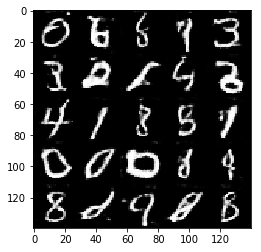

Epochs: 2/2 step: 1820/1874  Discriminator loss: 1.0583 Generator loss: 0.8985
Epochs: 2/2 step: 1840/1874  Discriminator loss: 0.9752 Generator loss: 1.0884
Epochs: 2/2 step: 1860/1874  Discriminator loss: 0.9957 Generator loss: 1.9178
Epochs: 2/2 step: 1874/1874  Discriminator loss: 0.7441 Generator loss: 1.3557


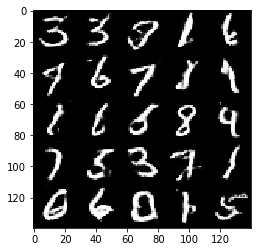

In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epochs: 1/1 step: 20/3165  Discriminator loss: 0.5209 Generator loss: 2.7084
Epochs: 1/1 step: 40/3165  Discriminator loss: 0.8427 Generator loss: 2.8977
Epochs: 1/1 step: 60/3165  Discriminator loss: 2.5331 Generator loss: 0.1936
Epochs: 1/1 step: 80/3165  Discriminator loss: 0.7702 Generator loss: 1.4590
Epochs: 1/1 step: 100/3165  Discriminator loss: 0.8776 Generator loss: 1.2645
Epochs: 1/1 step: 120/3165  Discriminator loss: 2.5988 Generator loss: 0.1579
Epochs: 1/1 step: 140/3165  Discriminator loss: 0.4690 Generator loss: 2.7552
Epochs: 1/1 step: 160/3165  Discriminator loss: 0.6129 Generator loss: 1.9376
Epochs: 1/1 step: 180/3165  Discriminator loss: 1.2411 Generator loss: 0.7199
Epochs: 1/1 step: 200/3165  Discriminator loss: 1.1011 Generator loss: 0.8426


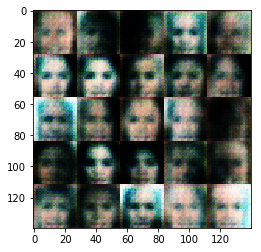

Epochs: 1/1 step: 220/3165  Discriminator loss: 1.2133 Generator loss: 0.7633
Epochs: 1/1 step: 240/3165  Discriminator loss: 1.4292 Generator loss: 3.2120
Epochs: 1/1 step: 260/3165  Discriminator loss: 1.0981 Generator loss: 0.7903
Epochs: 1/1 step: 280/3165  Discriminator loss: 0.5267 Generator loss: 2.3848
Epochs: 1/1 step: 300/3165  Discriminator loss: 1.6377 Generator loss: 0.4534
Epochs: 1/1 step: 320/3165  Discriminator loss: 0.5927 Generator loss: 2.7368
Epochs: 1/1 step: 340/3165  Discriminator loss: 2.4070 Generator loss: 2.9040
Epochs: 1/1 step: 360/3165  Discriminator loss: 0.6940 Generator loss: 2.0552
Epochs: 1/1 step: 380/3165  Discriminator loss: 1.2610 Generator loss: 0.6040
Epochs: 1/1 step: 400/3165  Discriminator loss: 0.5778 Generator loss: 2.2662


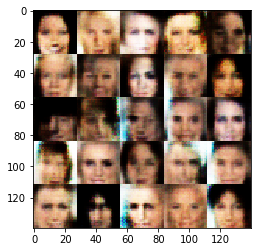

Epochs: 1/1 step: 420/3165  Discriminator loss: 0.9879 Generator loss: 1.7062
Epochs: 1/1 step: 440/3165  Discriminator loss: 1.2160 Generator loss: 0.6251
Epochs: 1/1 step: 460/3165  Discriminator loss: 0.9733 Generator loss: 2.4597
Epochs: 1/1 step: 480/3165  Discriminator loss: 0.5545 Generator loss: 2.5811
Epochs: 1/1 step: 500/3165  Discriminator loss: 1.8971 Generator loss: 0.2910
Epochs: 1/1 step: 520/3165  Discriminator loss: 0.4440 Generator loss: 3.5203
Epochs: 1/1 step: 540/3165  Discriminator loss: 0.5269 Generator loss: 2.2509
Epochs: 1/1 step: 560/3165  Discriminator loss: 0.8565 Generator loss: 1.1522
Epochs: 1/1 step: 580/3165  Discriminator loss: 0.6319 Generator loss: 2.5872
Epochs: 1/1 step: 600/3165  Discriminator loss: 0.6642 Generator loss: 3.4002


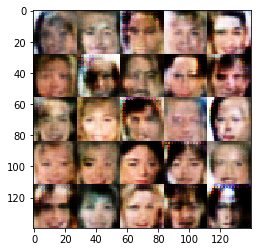

Epochs: 1/1 step: 620/3165  Discriminator loss: 1.1465 Generator loss: 0.6996
Epochs: 1/1 step: 640/3165  Discriminator loss: 0.5463 Generator loss: 2.5939
Epochs: 1/1 step: 660/3165  Discriminator loss: 0.9537 Generator loss: 1.7565
Epochs: 1/1 step: 680/3165  Discriminator loss: 0.8388 Generator loss: 1.1009
Epochs: 1/1 step: 700/3165  Discriminator loss: 0.7028 Generator loss: 1.7597
Epochs: 1/1 step: 720/3165  Discriminator loss: 0.5940 Generator loss: 1.9030
Epochs: 1/1 step: 740/3165  Discriminator loss: 1.5125 Generator loss: 0.4916
Epochs: 1/1 step: 760/3165  Discriminator loss: 1.0955 Generator loss: 1.4835
Epochs: 1/1 step: 780/3165  Discriminator loss: 0.5728 Generator loss: 1.9897
Epochs: 1/1 step: 800/3165  Discriminator loss: 0.5474 Generator loss: 2.2220


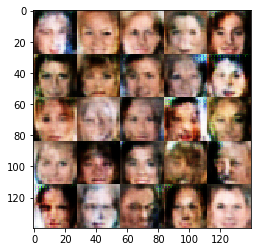

Epochs: 1/1 step: 820/3165  Discriminator loss: 0.8389 Generator loss: 1.3179
Epochs: 1/1 step: 840/3165  Discriminator loss: 0.7744 Generator loss: 1.3366
Epochs: 1/1 step: 860/3165  Discriminator loss: 0.6349 Generator loss: 1.6253
Epochs: 1/1 step: 880/3165  Discriminator loss: 0.6045 Generator loss: 1.7303
Epochs: 1/1 step: 900/3165  Discriminator loss: 0.5269 Generator loss: 2.5758
Epochs: 1/1 step: 920/3165  Discriminator loss: 0.7680 Generator loss: 1.2566
Epochs: 1/1 step: 940/3165  Discriminator loss: 0.6178 Generator loss: 2.2051
Epochs: 1/1 step: 960/3165  Discriminator loss: 1.3715 Generator loss: 0.5908
Epochs: 1/1 step: 980/3165  Discriminator loss: 0.9894 Generator loss: 1.4522
Epochs: 1/1 step: 1000/3165  Discriminator loss: 0.7693 Generator loss: 1.1936


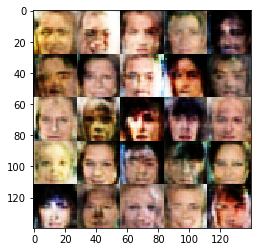

Epochs: 1/1 step: 1020/3165  Discriminator loss: 1.1395 Generator loss: 0.7240
Epochs: 1/1 step: 1040/3165  Discriminator loss: 0.7605 Generator loss: 1.1763
Epochs: 1/1 step: 1060/3165  Discriminator loss: 0.6733 Generator loss: 2.3752
Epochs: 1/1 step: 1080/3165  Discriminator loss: 0.6680 Generator loss: 1.9162
Epochs: 1/1 step: 1100/3165  Discriminator loss: 0.9838 Generator loss: 1.0859
Epochs: 1/1 step: 1120/3165  Discriminator loss: 0.7625 Generator loss: 2.5102
Epochs: 1/1 step: 1140/3165  Discriminator loss: 0.6408 Generator loss: 2.1083
Epochs: 1/1 step: 1160/3165  Discriminator loss: 0.8663 Generator loss: 1.0503
Epochs: 1/1 step: 1180/3165  Discriminator loss: 0.7020 Generator loss: 1.4294
Epochs: 1/1 step: 1200/3165  Discriminator loss: 0.8362 Generator loss: 2.9906


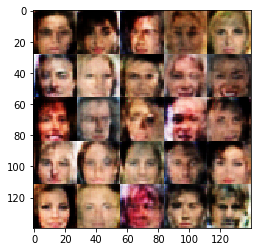

Epochs: 1/1 step: 1220/3165  Discriminator loss: 1.2615 Generator loss: 0.6016
Epochs: 1/1 step: 1240/3165  Discriminator loss: 1.4297 Generator loss: 0.4641
Epochs: 1/1 step: 1260/3165  Discriminator loss: 1.3194 Generator loss: 0.6008
Epochs: 1/1 step: 1280/3165  Discriminator loss: 1.2006 Generator loss: 0.6444
Epochs: 1/1 step: 1300/3165  Discriminator loss: 0.7693 Generator loss: 1.4857
Epochs: 1/1 step: 1320/3165  Discriminator loss: 0.8979 Generator loss: 1.2280
Epochs: 1/1 step: 1340/3165  Discriminator loss: 0.5593 Generator loss: 2.5636
Epochs: 1/1 step: 1360/3165  Discriminator loss: 0.7070 Generator loss: 1.6049
Epochs: 1/1 step: 1380/3165  Discriminator loss: 0.4157 Generator loss: 4.3312
Epochs: 1/1 step: 1400/3165  Discriminator loss: 0.4322 Generator loss: 2.9740


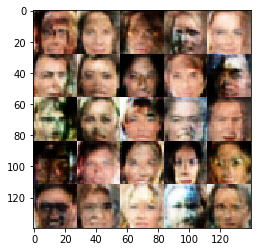

Epochs: 1/1 step: 1420/3165  Discriminator loss: 1.6082 Generator loss: 2.2309
Epochs: 1/1 step: 1440/3165  Discriminator loss: 0.8037 Generator loss: 2.2161
Epochs: 1/1 step: 1460/3165  Discriminator loss: 0.5750 Generator loss: 1.9022
Epochs: 1/1 step: 1480/3165  Discriminator loss: 1.3125 Generator loss: 0.5641
Epochs: 1/1 step: 1500/3165  Discriminator loss: 1.2187 Generator loss: 0.8517
Epochs: 1/1 step: 1520/3165  Discriminator loss: 1.0234 Generator loss: 0.9175
Epochs: 1/1 step: 1540/3165  Discriminator loss: 1.0434 Generator loss: 0.9077
Epochs: 1/1 step: 1560/3165  Discriminator loss: 0.8186 Generator loss: 1.4071
Epochs: 1/1 step: 1580/3165  Discriminator loss: 0.6120 Generator loss: 2.1889
Epochs: 1/1 step: 1600/3165  Discriminator loss: 0.9713 Generator loss: 0.9100


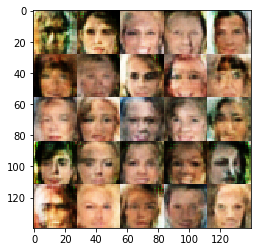

Epochs: 1/1 step: 1620/3165  Discriminator loss: 1.0955 Generator loss: 0.8130
Epochs: 1/1 step: 1640/3165  Discriminator loss: 0.7506 Generator loss: 1.2922
Epochs: 1/1 step: 1660/3165  Discriminator loss: 0.8141 Generator loss: 1.2947
Epochs: 1/1 step: 1680/3165  Discriminator loss: 1.0755 Generator loss: 2.2226
Epochs: 1/1 step: 1700/3165  Discriminator loss: 1.3832 Generator loss: 2.9119
Epochs: 1/1 step: 1720/3165  Discriminator loss: 0.7282 Generator loss: 1.3040
Epochs: 1/1 step: 1740/3165  Discriminator loss: 1.0026 Generator loss: 1.5498
Epochs: 1/1 step: 1760/3165  Discriminator loss: 0.8944 Generator loss: 2.2088
Epochs: 1/1 step: 1780/3165  Discriminator loss: 0.8231 Generator loss: 1.6768
Epochs: 1/1 step: 1800/3165  Discriminator loss: 0.9186 Generator loss: 0.9231


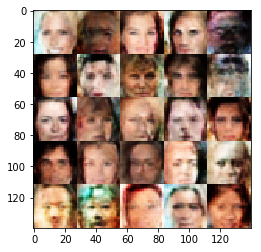

Epochs: 1/1 step: 1820/3165  Discriminator loss: 0.9616 Generator loss: 0.9103
Epochs: 1/1 step: 1840/3165  Discriminator loss: 0.6555 Generator loss: 1.5407
Epochs: 1/1 step: 1860/3165  Discriminator loss: 0.6647 Generator loss: 1.4693
Epochs: 1/1 step: 1880/3165  Discriminator loss: 0.6981 Generator loss: 2.1141
Epochs: 1/1 step: 1900/3165  Discriminator loss: 0.4945 Generator loss: 2.4145
Epochs: 1/1 step: 1920/3165  Discriminator loss: 1.0168 Generator loss: 0.8591
Epochs: 1/1 step: 1940/3165  Discriminator loss: 1.8258 Generator loss: 0.3595
Epochs: 1/1 step: 1960/3165  Discriminator loss: 0.9319 Generator loss: 2.1330
Epochs: 1/1 step: 1980/3165  Discriminator loss: 0.5157 Generator loss: 2.0968
Epochs: 1/1 step: 2000/3165  Discriminator loss: 1.1163 Generator loss: 0.6929


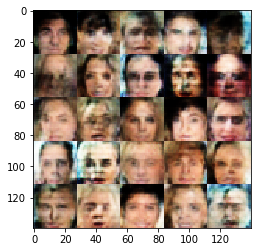

Epochs: 1/1 step: 2020/3165  Discriminator loss: 1.2994 Generator loss: 1.9137
Epochs: 1/1 step: 2040/3165  Discriminator loss: 0.9757 Generator loss: 2.0648
Epochs: 1/1 step: 2060/3165  Discriminator loss: 0.4034 Generator loss: 4.7992
Epochs: 1/1 step: 2080/3165  Discriminator loss: 1.8545 Generator loss: 3.0261
Epochs: 1/1 step: 2100/3165  Discriminator loss: 1.0651 Generator loss: 1.3696
Epochs: 1/1 step: 2120/3165  Discriminator loss: 0.7606 Generator loss: 2.0037
Epochs: 1/1 step: 2140/3165  Discriminator loss: 0.9703 Generator loss: 0.9241
Epochs: 1/1 step: 2160/3165  Discriminator loss: 0.9107 Generator loss: 0.9787
Epochs: 1/1 step: 2180/3165  Discriminator loss: 0.5839 Generator loss: 1.7808
Epochs: 1/1 step: 2200/3165  Discriminator loss: 0.6435 Generator loss: 1.7460


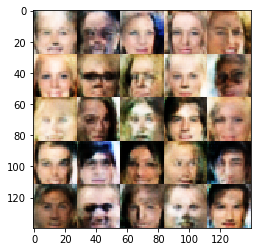

Epochs: 1/1 step: 2220/3165  Discriminator loss: 2.9540 Generator loss: 0.1371
Epochs: 1/1 step: 2240/3165  Discriminator loss: 0.6239 Generator loss: 2.3666
Epochs: 1/1 step: 2260/3165  Discriminator loss: 0.9867 Generator loss: 0.8574
Epochs: 1/1 step: 2280/3165  Discriminator loss: 1.4301 Generator loss: 1.5627
Epochs: 1/1 step: 2300/3165  Discriminator loss: 0.7767 Generator loss: 1.3393
Epochs: 1/1 step: 2320/3165  Discriminator loss: 1.9013 Generator loss: 2.9291
Epochs: 1/1 step: 2340/3165  Discriminator loss: 0.8920 Generator loss: 0.9988
Epochs: 1/1 step: 2360/3165  Discriminator loss: 0.6296 Generator loss: 2.0571
Epochs: 1/1 step: 2380/3165  Discriminator loss: 0.9670 Generator loss: 0.8740
Epochs: 1/1 step: 2400/3165  Discriminator loss: 1.3736 Generator loss: 0.5853


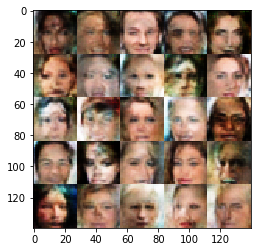

Epochs: 1/1 step: 2420/3165  Discriminator loss: 1.0208 Generator loss: 0.8251
Epochs: 1/1 step: 2440/3165  Discriminator loss: 0.8780 Generator loss: 1.4290
Epochs: 1/1 step: 2460/3165  Discriminator loss: 0.8408 Generator loss: 1.0525
Epochs: 1/1 step: 2480/3165  Discriminator loss: 0.4771 Generator loss: 2.8851
Epochs: 1/1 step: 2500/3165  Discriminator loss: 0.9320 Generator loss: 1.1387
Epochs: 1/1 step: 2520/3165  Discriminator loss: 0.7236 Generator loss: 2.3148
Epochs: 1/1 step: 2540/3165  Discriminator loss: 2.8682 Generator loss: 3.8979
Epochs: 1/1 step: 2560/3165  Discriminator loss: 0.4095 Generator loss: 3.4444
Epochs: 1/1 step: 2580/3165  Discriminator loss: 0.8471 Generator loss: 1.1832
Epochs: 1/1 step: 2600/3165  Discriminator loss: 1.1709 Generator loss: 0.6305


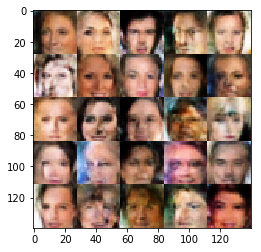

Epochs: 1/1 step: 2620/3165  Discriminator loss: 2.3384 Generator loss: 0.2247
Epochs: 1/1 step: 2640/3165  Discriminator loss: 0.9361 Generator loss: 0.9287
Epochs: 1/1 step: 2660/3165  Discriminator loss: 0.9260 Generator loss: 1.1327
Epochs: 1/1 step: 2680/3165  Discriminator loss: 0.7283 Generator loss: 1.5620
Epochs: 1/1 step: 2700/3165  Discriminator loss: 1.3555 Generator loss: 0.5386
Epochs: 1/1 step: 2720/3165  Discriminator loss: 0.9823 Generator loss: 1.1298
Epochs: 1/1 step: 2740/3165  Discriminator loss: 1.0548 Generator loss: 0.8589
Epochs: 1/1 step: 2760/3165  Discriminator loss: 0.8420 Generator loss: 1.7186
Epochs: 1/1 step: 2780/3165  Discriminator loss: 0.5178 Generator loss: 2.2276
Epochs: 1/1 step: 2800/3165  Discriminator loss: 1.1483 Generator loss: 0.6803


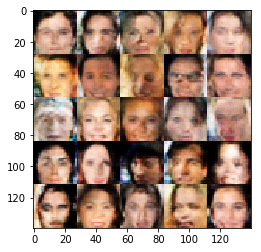

Epochs: 1/1 step: 2820/3165  Discriminator loss: 1.3423 Generator loss: 0.5291
Epochs: 1/1 step: 2840/3165  Discriminator loss: 0.6943 Generator loss: 1.9544
Epochs: 1/1 step: 2860/3165  Discriminator loss: 0.7840 Generator loss: 1.3920
Epochs: 1/1 step: 2880/3165  Discriminator loss: 1.0486 Generator loss: 0.8016
Epochs: 1/1 step: 2900/3165  Discriminator loss: 1.7110 Generator loss: 0.3518
Epochs: 1/1 step: 2920/3165  Discriminator loss: 1.0024 Generator loss: 1.6310
Epochs: 1/1 step: 2940/3165  Discriminator loss: 0.9340 Generator loss: 1.6579
Epochs: 1/1 step: 2960/3165  Discriminator loss: 0.7445 Generator loss: 1.6971
Epochs: 1/1 step: 2980/3165  Discriminator loss: 0.8634 Generator loss: 1.2388
Epochs: 1/1 step: 3000/3165  Discriminator loss: 0.9865 Generator loss: 0.9189


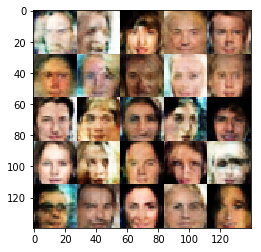

Epochs: 1/1 step: 3020/3165  Discriminator loss: 1.4630 Generator loss: 0.4859
Epochs: 1/1 step: 3040/3165  Discriminator loss: 0.9038 Generator loss: 1.0421
Epochs: 1/1 step: 3060/3165  Discriminator loss: 0.8299 Generator loss: 2.4243
Epochs: 1/1 step: 3080/3165  Discriminator loss: 0.7383 Generator loss: 1.6157
Epochs: 1/1 step: 3100/3165  Discriminator loss: 0.8795 Generator loss: 1.0441
Epochs: 1/1 step: 3120/3165  Discriminator loss: 0.8528 Generator loss: 1.3041
Epochs: 1/1 step: 3140/3165  Discriminator loss: 0.8210 Generator loss: 1.0911
Epochs: 1/1 step: 3160/3165  Discriminator loss: 0.7979 Generator loss: 1.3134
Epochs: 1/1 step: 3165/3165  Discriminator loss: 0.6442 Generator loss: 2.1894


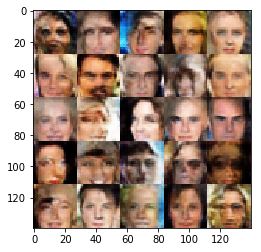

In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.